In [1]:
import pandas as pd
from glob import glob
import os
from os import path as osp
from matplotlib import pyplot as plt
import matplotlib

In [2]:
import ete3.ncbi_taxonomy
ncbi = ete3.ncbi_taxonomy.NCBITaxa()

In [3]:
def get_desired_ranks(taxid, desired_ranks, tolist=False):
    """ From stackoverflow
        https://stackoverflow.com/questions/36503042/how-to-get-taxonomic-specific-ids-for-kingdom-phylum-class-order-family-gen
    """
    try:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
        ranks2lineage = dict((rank, taxid) for (taxid, rank) in lineage2ranks.items())
        if tolist: return [ranks2lineage.get(rank, 0) for rank in desired_ranks]
        else:      return {f'{rank}_id': ranks2lineage.get(rank, 0) for rank in desired_ranks}
    except:
        print(f"retrieval of the lineage of {taxid} failed")
        if tolist: return [0 for rank in desired_ranks]
        else:      return {f'{rank}_id': 0 for rank in desired_ranks}

In [4]:
def get_list_rank(taxids, desired_rank="species"):
    res = []
    for taxid in taxids:
        name = get_desired_ranks(taxid, [desired_rank], tolist=True)[0]
        res.append(name)
    return res

In [5]:
pd.set_option('precision', 5)
matplotlib.style.use('ggplot')

In [6]:
out_figs = "/mnt/data/results/extended_abstract"

## tests

In [7]:
import shutil
from glob import glob

## Parameters: b, k, s

In [8]:
input_folder = "/mnt/data/results/2"
identifier = ".auc.tsv"

In [9]:
dfs = {}
for file in glob(f"{input_folder}/*{identifier}"):
    if "SyntReads" in file: continue
    if "silico-10-bacteria-20k-reads" in file:
        title = osp.basename(file).split(".")[0].split("20k-reads-")[1]
        print(title)
        df = pd.read_csv(file, sep="\t")
        scaled = df.iloc[1:].copy()
        scaled["auc_value"] /= df["auc_value"][0]
        dfs[title] = scaled

1k-2k
2k-5k
500-1k
5k-10k


In [10]:
ordered = {}
for key in ("500-1k", "1k-2k", "2k-5k", "5k-10k"):
    ordered[key] = dfs[key]

In [11]:
aucs = pd.concat(ordered)

In [12]:
for param in aucs.parameters.unique():
    v = aucs[aucs.parameters == param].shape[0]
    if v <= 3:
        print(v, param, aucs[aucs.parameters == param].index[0])

1 b10_k4_s5000_ ('2k-5k', 2)
1 b10_k4_s25000_ ('2k-5k', 4)
1 b10_k4_s50000_ ('2k-5k', 5)
1 b50_k4_s10000_ ('5k-10k', 4)


In [13]:
filtered = aucs[(aucs.bins == 10) & (aucs.s == 10000)].copy()
filtered.drop(columns=["parameters", "bins", "s", ], inplace=True)
filtered.k = filtered.k.astype(int)
filtered

k  auc_value
500-1k 1  3    0.98024
       2  4    1.00518
       3  5    0.98937
1k-2k  1  3    0.97550
       2  4    0.98798
       3  5    0.99856
2k-5k  1  3    0.97097
       3  4    0.99053
       6  5    0.98674
5k-10k 1  3    0.99864
       2  4    0.99972
       3  5    0.99382

In [14]:
filtered.reset_index(inplace=True)
filtered.drop(columns=["level_1"], inplace=True)

In [15]:
filtered.set_index(["level_0", "k"], inplace=True, drop=True)
filtered.index.rename(["read_length", "k"], inplace=True)

In [16]:
unstacked = filtered.unstack()
unstacked = unstacked.reindex(("500-1k", "1k-2k", "2k-5k", "5k-10k"))
unstacked

auc_value                  
k                   3        4        5
read_length                            
500-1k        0.98024  1.00518  0.98937
1k-2k         0.97550  0.98798  0.99856
2k-5k         0.97097  0.99053  0.98674
5k-10k        0.99864  0.99972  0.99382

In [17]:
matplotlib.style.use('ggplot')

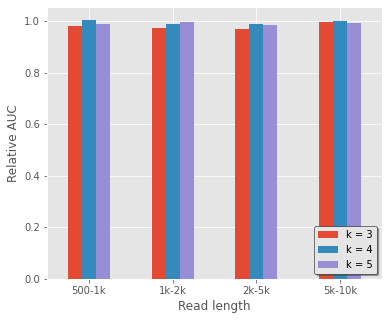

In [18]:
ax = unstacked.plot.bar(rot=0, figsize=(6,5), legend=None, )  # title="Influence of read length for Plot-ME",
ax.set(ylabel="Relative AUC", xlabel="Read length")
ax.legend(["k = 3", "k = 4", "k = 5", ], loc='lower right', edgecolor='black', frameon=True, shadow=True)
fig = ax.get_figure()

## Average AUC for various k / s values

In [33]:
dfs = {}
for file in glob(f"{input_folder}/*{identifier}"):
    if "SyntReads" in file or "silico-10-bacteria-20k-reads" in file or "Mock_10000-uniform" in file: continue
    title = osp.basename(file).split(".")[0]
    print(title)
    df = pd.read_csv(file, sep="\t")
    scaled = df.iloc[1:].copy()
    scaled["auc_value"] /= df["auc_value"][0]
    dfs[title] = scaled

silico-10-bacteria-100k-reads
Mock_100000-bacteria-l1000-q10
silico-30p-human-70p-bac


In [34]:
aucs = pd.concat(dfs)

In [35]:
filtered = aucs[(aucs.bins == 10) & (aucs.s != 1)].copy()
filtered.drop(columns=["parameters", "bins"], inplace=True)
filtered.k = filtered.k.astype(int)
filtered.s = filtered.s.astype(int)
filtered

k      s  auc_value
silico-10-bacteria-100k-reads  1   3   5000    0.97037
                               2   3  10000    0.97355
                               3   3  25000    0.97806
                               4   3  50000    0.99066
                               5   4   5000    0.96662
                               6   4  10000    0.97595
                               7   4  25000    0.98596
                               8   4  50000    0.96533
                               9   5  10000    0.98390
                               10  5  25000    0.98398
                               11  5  50000    0.97781
Mock_100000-bacteria-l1000-q10 1   3   5000    1.02677
                               2   3  10000    0.98120
                               3   3  25000    1.01453
                               4   3  50000    0.97189
                               5   4   5000    1.02450
                               6   4  10000    0.99048
                               7   4  25000    1.01710
                               8   4  50000    0.98433
                               9   5  10000    1.00955
                               10  5  25000    1.01384
                               11  5  50000    0.96634
silico-30p-human-70p-bac       1   3   5000    1.10241
                               2   3  10000    1.08722
                               3   3  25000    1.12274
                               4   3  50000    1.06687
                               5   4   5000    1.07256
                               6   4  10000    1.09521
                               7   4  25000    1.06507
                               8   4  50000    1.06425
                               9   5  10000    1.09454
                               10  5  25000    1.06921
                               11  5  50000    1.00915

In [36]:
filtered.groupby(["k", "s"]).mean().unstack()

auc_value                           
s     5000     10000    25000    50000
k                                     
3   1.03318  1.01399  1.03844  1.00981
4   1.02123  1.02055  1.02271  1.00464
5       NaN  1.02933  1.02234  0.98443

In [37]:
moyenne = filtered.groupby(["k", "s"]).mean().unstack()
deviation = filtered.groupby(["k", "s"]).std().unstack()

In [38]:
matplotlib.style.use('seaborn')

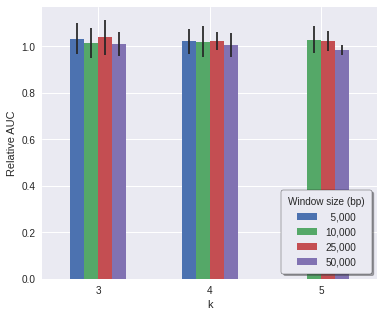

In [40]:
ax = moyenne.plot(kind='bar', yerr=deviation, rot=0, figsize=(6,5), legend=None)
ax.set(ylabel="Relative AUC")
ax.legend(["  5,000", "10,000", "25,000", "50,000"], loc='lower right', title="Window size (bp)", frameon=True, shadow=True, edgecolor='black', borderpad=0.7)
fig = ax.get_figure()

## Average AUC for various bins values

In [49]:
aucs.index.get_level_values(0).unique().tolist()

['silico-10-bacteria-100k-reads',
 'Mock_100000-bacteria-l1000-q10',
 'silico-30p-human-70p-bac']

In [52]:
def plot_fig(aucs):
    filtered = aucs[aucs.s == 10000].copy()
    filtered.drop(columns=["parameters", "s"], inplace=True)
    filtered.k    = filtered.k.astype(int)
    filtered.bins = filtered.bins.astype(int)

    filtered.groupby(["bins", "k"]).mean().unstack()

    moyenne = filtered.groupby(["bins", "k"]).mean().unstack()
    deviation = filtered.groupby(["bins", "k"]).std().unstack()

#     matplotlib.style.available
    matplotlib.style.use('ggplot')
    ax = moyenne.plot(kind='bar', yerr=deviation, rot=0, figsize=(5,5), legend=None)
    ax.set(ylabel="Relative AUC")
    ax.legend(["3", "4", "5"], loc='lower right', title="k", frameon=True, shadow=True, edgecolor='black', borderpad=0.7)
    fig = ax.get_figure()
    return fig

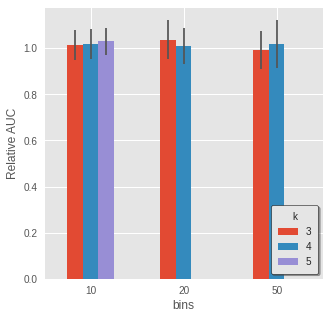

In [53]:
fig = plot_fig(aucs)

In [54]:
fig.savefig(osp.join(out_figs, "bins_compare"))

In [7]:
input_tsv = "/mnt/5TB/results/2/Mock_100000-bacteria-l1000-q10.auc.tsv"

In [40]:
df = pd.read_csv(input_tsv, sep="\t")

In [41]:
df

,parameters,bins,k,s,auc_value
0,no-binning,1,NaN,NaN,0.29002
1,b10_k3_s5000_,10,3.0,5000.0,0.29779
2,b10_k3_s10000_,10,3.0,10000.0,0.28457
3,b10_k3_s25000_,10,3.0,25000.0,0.29423
4,b10_k3_s50000_,10,3.0,50000.0,0.28187
5,b10_k4_s5000_,10,4.0,5000.0,0.29713
6,b10_k4_s10000_,10,4.0,10000.0,0.28726
7,b10_k4_s25000_,10,4.0,25000.0,0.29498
8,b10_k4_s50000_,10,4.0,50000.0,0.28548
9,b10_k5_s10000_,10,5.0,10000.0,0.29279


In [48]:
# Removing no-binning value, and scaling other auc values by it
scaled = df.iloc[1:].copy()
scaled["auc_value"] /= df["auc_value"][0]

In [47]:
# subset = df[df.ground_truth > 0].sort_values(ascending=False, by=["ground_truth", ])
max_val = df.auc_value.max()
scaled.style.background_gradient(subset=["bins"], cmap='viridis') \
    .bar(subset=["k"], color="cyan", vmin=2, vmax=5.5) \
    .bar(subset=["s"], color="grey", vmin=0, vmax=55000) \
    .bar(subset=["auc_value"], color="#5fba7d",)

,parameters,bins,k,s,auc_value
0,no-binning,1,nan,nan,1
1,b10_k3_s5000_,10,3,5000,1.0268
2,b10_k3_s10000_,10,3,10000,0.9812
3,b10_k3_s25000_,10,3,25000,1.0145
4,b10_k3_s50000_,10,3,50000,0.97189
5,b10_k4_s5000_,10,4,5000,1.0245
6,b10_k4_s10000_,10,4,10000,0.99048
7,b10_k4_s25000_,10,4,25000,1.0171
8,b10_k4_s50000_,10,4,50000,0.98433
9,b10_k5_s10000_,10,5,10000,1.0095


In [36]:
df[["b", "k", "s"]] = df.parameters.str.split("_", expand=True)

In [37]:
df.loc[0, "b"] = "0"
df.loc[0, "k"] = "0"
df.loc[0, "s"] = "0"

In [38]:
for letter in ("b", "k", "s"):
    df[letter] = df[letter].str.replace(letter, "").astype("int")

In [39]:
df

,parameters,auc_value,b,k,s
0,no-binning,0.2900,0,0,0
1,b10_k3_s5000,0.2978,10,3,5000
2,b10_k3_s10000,0.2846,10,3,10000
3,b10_k4_s5000,0.2482,10,4,5000
4,b10_k4_s10000,0.2873,10,4,10000
5,b20_k3_s5000,0.2925,20,3,5000
6,b20_k3_s10000,0.2900,20,3,10000
7,b20_k4_s10000,0.2796,20,4,10000
8,b20_k4_s25000,0.2965,20,4,25000
9,b50_k3_s5000,0.2766,50,3,5000


In [40]:
df2 = pd.DataFrame({
    "no-binning": [0.2900, 0.2900, 0.2900],
    "k3_s5000": [0.2978, 0.2925, 0.2766],
    "k3_s10000": [0.2846, 0.2900, 0.2747],
    "k4_s5000": [0.2482, None, None],
    "k4_s10000": [0.2873, 0.2796, 0.2772],
    "k4_s25000": [None, 0.2965, 0.2570],
}, index=[10, 20, 50])

In [41]:
df2

,no-binning,k3_s5000,k3_s10000,k4_s5000,k4_s10000,k4_s25000
10,0.29,0.2978,0.2846,0.2482,0.2873,NaN
20,0.29,0.2925,0.2900,NaN,0.2796,0.2965
50,0.29,0.2766,0.2747,NaN,0.2772,0.2570


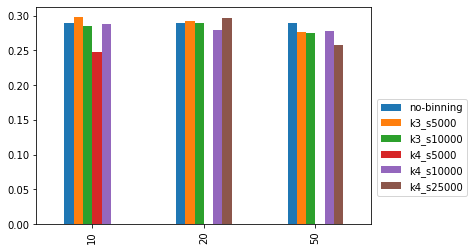

In [42]:
df2.plot.bar().legend(bbox_to_anchor=(1.3, 0.6))

## Read length

## Max index size

In [66]:
no_bin_hash = "/mnt/5TB/Segmentation/no-binning/oplant-vertebrate/kraken2/k35_l31_s7/hash.k2d"
print(f"Without binning, the hash table is {osp.getsize(no_bin_hash)/10**9:.2f} GB")

for bin_size in (10, 20, 50):
    folder = f"/mnt/5TB/Segmentation/k4_s10000/minikm_b{bin_size}_k4_s10000_oplant-vertebrate/kraken2/k35_l31_s7"
    sizes = []
    for folder in os.scandir(folder):
        if not folder.is_dir():
            continue
        p = osp.join(folder.path, "hash.k2d")
        size = osp.getsize(p)
        sizes.append(size)
    highest = max(sizes)
    total = sum(sizes)
    print(f"For {bin_size} bins, biggest hash is {highest/10**9:.2f} GB, total of all hashes is {total/10**9:.2f} GB")

Without binning, the hash table is 33.02 GB
For 10 bins, biggest hash is 6.60 GB, total of all hashes is 34.88 GB
For 20 bins, biggest hash is 3.60 GB, total of all hashes is 35.71 GB
For 50 bins, biggest hash is 2.13 GB, total of all hashes is 37.59 GB


In [ ]:
hash_size = pd.DataFrame({})

In [22]:
root = "/mnt/hdd1000/ONT_Mock_Communities/"
titles = []
gather = []
for f in os.scandir(root):
    if "silico-10" in f.name:
        title = f.name.split("silico-10-bacteria-20k-reads-")[1].split(".")[0]
        files = [g.path for g in os.scandir(f) if g.name.endswith(".reads_details.pd")]
        if len(files) == 1:
            df = pd.read_pickle(files[0])[["length"]].describe().T
            df.index = [title]
            gather.append(df)
            titles.append(title)

In [23]:
df

,count,mean,std,min,25%,50%,75%,max
2k-5k,20000.0,3240.4257,869.444736,2001.0,2465.0,3093.0,3957.0,4999.0


In [29]:
summary = pd.concat(gather, )
summary.drop(columns=["count", "25%", "75%"], inplace=True)

In [37]:
summary.sort_values(by=["mean"])

,mean,std,min,50%,max
500-1k,761,146,501,765,999
1k-2k,1549,277,1001,1569,1999
2k-5k,3240,869,2001,3093,4999
5k-10k,7066,1421,5001,6851,9999


In [6]:
summuray = pd.read_pickle("/mnt/hdd1000/ONT_Mock_Communities/silico-10-bacteria-20k-reads-2k-5k/silico-10-bacteria-20k-reads-2k-5k.summary.pd")

In [7]:
summuray

,taxon,species,kingdom,nb_of_reads,avg_length,avg_quality,file_path,date_added,percentage
0,40214,Acinetobacter johnsonii,bacteria,2000,3310,1,/mnt/data/reads-fastq/PacBio/isolates/acinecto...,2020-03-03,1e+01
1,655816,Bacillus subtilis subsp. spizizenii str. W23,bacteria,2000,3708,,/mnt/data/reads-fastq/PacBio/isolates/bacillus...,2020-03-03,1e+01
2,983594,Burkholderia cepacia ATCC 25416,bacteria,500,3596,,/mnt/data/reads-fastq/PacBio/isolates/burkhold...,2020-03-03,2e+00
3,474186,Enterococcus faecalis OG1RF,bacteria,200,3632,,/mnt/data/reads-fastq/PacBio/isolates/enteroco...,2020-03-03,1e+00
4,83333,Escherichia coli K-12,bacteria,400,3565,,/mnt/data/reads-fastq/PacBio/isolates/escheric...,2020-03-03,2e+00
5,566546,Escherichia coli W,bacteria,1000,3542,,/mnt/data/reads-fastq/PacBio/isolates/escheric...,2020-03-03,5e+00
6,76857,Fusobacterium nucleatum subsp. polymorphum,bacteria,100,3023,1,/mnt/data/reads-fastq/PacBio/isolates/fusobact...,2020-03-03,5e-01
7,85963,Helicobacter pylori J99,bacteria,200,3545,,/mnt/data/reads-fastq/PacBio/isolates/helicoba...,2020-03-03,1e+00
8,1263871,Klebsiella pneumoniae ATCC BAA-2146,bacteria,1500,3535,,/mnt/data/reads-fastq/PacBio/isolates/klebsiel...,2020-03-03,8e+00
9,985002,Staphylococcus argenteus,bacteria,8000,3047,1,/mnt/data/reads-fastq/PacBio/isolates/staphylo...,2020-03-03,4e+01


In [2]:
p = "/mnt/5TB/Segmentation/Test-Data/Synthetic_from_Genomes/100000-SyntReads_20-BacGut/100000-SyntReads_20-BacGut.pd"

In [3]:
df = pd.read_pickle(p)

In [8]:
taxids = df.taxon.unique().tolist()

In [9]:
ncbi.translate_to_names(taxids)

['Enterococcus faecalis str. Symbioflor 1',
 'Enterococcus faecalis ATCC 29212',
 'Enterococcus faecalis',
 'Escherichia coli',
 'Escherichia coli O145:H28 str. RM12761',
 'Staphylococcus aureus subsp. aureus T0131',
 'Staphylococcus aureus',
 'Klebsiella pneumoniae',
 'Klebsiella pneumoniae subsp. pneumoniae 1158',
 'Bacteroides fragilis NCTC 9343',
 'Enterobacter cloacae P101',
 'Bifidobacterium longum',
 'Lactobacillus plantarum',
 'Clostridium perfringens',
 'Proteus mirabilis',
 'Pseudomonas aeruginosa RP73',
 'Parabacteroides distasonis ATCC 8503']

In [14]:
get_list_rank(taxids)

[1351,
 1351,
 1351,
 562,
 562,
 1280,
 1280,
 573,
 573,
 817,
 550,
 216816,
 1590,
 1502,
 584,
 287,
 823]

In [13]:
ncbi.translate_to_names(get_list_rank(taxids))

['Enterococcus faecalis',
 'Enterococcus faecalis',
 'Enterococcus faecalis',
 'Escherichia coli',
 'Escherichia coli',
 'Staphylococcus aureus',
 'Staphylococcus aureus',
 'Klebsiella pneumoniae',
 'Klebsiella pneumoniae',
 'Bacteroides fragilis',
 'Enterobacter cloacae',
 'Bifidobacterium longum',
 'Lactobacillus plantarum',
 'Clostridium perfringens',
 'Proteus mirabilis',
 'Pseudomonas aeruginosa',
 'Parabacteroides distasonis']

In [10]:
df[df.taxon == 1280]

,taxon,category,start,end,name,description,fna_path,cluster
880762,1280,plasmid,0,10000,NZ_CP007455.1,|kraken:taxid|1280|s:0-e:9999|NZ_CP007455.1 St...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,1
880763,1280,plasmid,10000,20000,NZ_CP007455.1,|kraken:taxid|1280|s:10000-e:19999|NZ_CP007455...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,4
880764,1280,complete genome,0,10000,NZ_CP007454.1,|kraken:taxid|1280|s:0-e:9999|NZ_CP007454.1 St...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,4
880765,1280,complete genome,10000,20000,NZ_CP007454.1,|kraken:taxid|1280|s:10000-e:19999|NZ_CP007454...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,4
880766,1280,complete genome,20000,30000,NZ_CP007454.1,|kraken:taxid|1280|s:20000-e:29999|NZ_CP007454...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,4
...,...,...,...,...,...,...,...,...
4726981,1280,chromosome,2900000,2910000,NZ_LR134351.1,|kraken:taxid|1280|s:2900000-e:2909999|NZ_LR13...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,1
4726982,1280,chromosome,2910000,2920000,NZ_LR134351.1,|kraken:taxid|1280|s:2910000-e:2919999|NZ_LR13...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,1
4726983,1280,chromosome,2920000,2930000,NZ_LR134351.1,|kraken:taxid|1280|s:2920000-e:2929999|NZ_LR13...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,1
4726984,1280,chromosome,2930000,2940000,NZ_LR134351.1,|kraken:taxid|1280|s:2930000-e:2939999|NZ_LR13...,/home/ubuntu/Data/NCBI/20190704/refseq/bacteri...,1


In [13]:
df[df.taxon == 46170].cluster.value_counts()

4    5638
1    4956
5     647
9     211
3      16
Name: cluster, dtype: int64